# 3) Machine Learning model

It is time to build our machine learning model with our data. This section is split into two parts:
1. We apply KMeans clustering algorithm to 1979 data. The algorithm creates well divided clusters that represent the wildfire susceptibility of the selected regions.
2. The clusters will be the labels for the supervised learning section. We will train a Random Forest algorithm; the model will be capable to predict the wildfire susceptibility of the remain years.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_pickle('Fire_danger.pkl')

In [3]:
df

,time,longitude,latitude,bi,danger_risk,dc,dmc,erc,ffmc,ic,isi,kbdi,sc
143,1979-06-01,0.00,54.25,0.0,1.0,4.941989,0.897482,0.0,39.412701,0.0,0.051276,0.475582,0.0
144,1979-06-01,0.00,54.00,0.0,1.0,5.105268,1.163779,0.0,46.037491,0.0,0.201392,0.509765,0.0
145,1979-06-01,0.00,53.75,0.0,1.0,5.202592,1.423807,0.0,50.706917,0.0,0.344205,0.640720,0.0
146,1979-06-01,0.00,53.50,0.0,1.0,5.721916,2.786665,0.0,65.214951,0.0,0.884310,0.980370,0.0
147,1979-06-01,0.00,53.25,0.0,1.0,5.741457,3.306364,1.0,67.533035,0.0,0.949178,1.028400,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174423806,2020-09-01,-0.25,38.25,0.0,3.5,458.990448,106.611412,0.0,86.399529,2.0,5.331127,83.025909,1.0
174423815,2020-09-01,-0.25,36.00,0.0,4.0,554.472107,123.896194,2.0,86.455887,0.0,8.603022,82.866753,0.0
174423816,2020-09-01,-0.25,35.75,6.0,4.0,584.553833,301.949432,4.0,88.970139,5.0,7.722607,105.309006,1.0
174423817,2020-09-01,-0.25,35.50,7.0,5.0,668.230286,599.772339,7.0,93.640953,8.0,12.611588,167.794479,1.0


## KMeans

Our data is basically ready to be fed to our model. We adopt the RobustScaler to rescale our data; RobustScaler using statistics that are robust to outliers and guarantees better performances and more defined clusters.

We assume 4 clusters; despite the inertia analysis (trought the "elbow-method") suggests to use more clusters, we believe that 4 is the ideal number in order to have clear and simple results. 

The results of KMeans fit with 1979 data produce a new label. The 4 cluster are reorganized in icreasing order of threat.

In [4]:
n_clusters=4

## Select and scale the data ##

times = df['time'].unique()[0:4]
df_1979 = df[df['time'].isin(times)]

X = df_1979.drop(['time'], axis=1)
scaler = RobustScaler()
scaled_X = scaler.fit_transform(X)

## KMeans model ##

kmeans = KMeans(n_clusters)
kmeans.fit(scaled_X)

## Reorder the centroids ##

new_centroids = []
magnitude = []
for center in kmeans.cluster_centers_:
    magnitude.append(np.sqrt(center.dot(center)))
idx_argsort = np.argsort(magnitude)
kmeans.cluster_centers_ = kmeans.cluster_centers_[idx_argsort]
kmeans.labels_ = kmeans.predict(scaled_X)

df_1979['label'] = kmeans.labels_

<ipython-input-4-1bb2a3ac2676>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1979['label'] = kmeans.labels_


Grouping the dataframe on the new label we can easily understand their meaning. We observe that every label is clearly divided in different range of values for every feature. Furthermore we see that the danger increases going to the southern and eastern regions of Europe, with Greece and Turkey that appears to be the most dangerous countries.

In [5]:
df_1979.groupby(['label']).mean()

,longitude,latitude,bi,danger_risk,dc,dmc,erc,ffmc,ic,isi,kbdi,sc
label,,,,,,,,,,,,
0,20.355764,55.026268,0.486823,1.105258,53.704288,10.529836,0.984916,63.476452,0.442263,1.463552,13.130837,0.109752
1,22.135347,49.300328,4.864974,2.518064,120.110939,43.827763,5.244824,85.756462,4.430265,5.613606,38.148048,0.926658
2,25.271933,42.529384,9.692693,4.763281,241.917053,156.243500,8.771844,92.182648,9.665038,14.424894,76.247841,2.030159
3,37.775915,36.366870,13.039634,5.730691,511.848541,596.738586,9.318089,96.457420,16.073171,22.639021,149.167984,3.261179


The figure below shows the results for the 4 months of 1979. Southern europe is most likely to danger wildfires, due to the harsher weather during the summer months. 

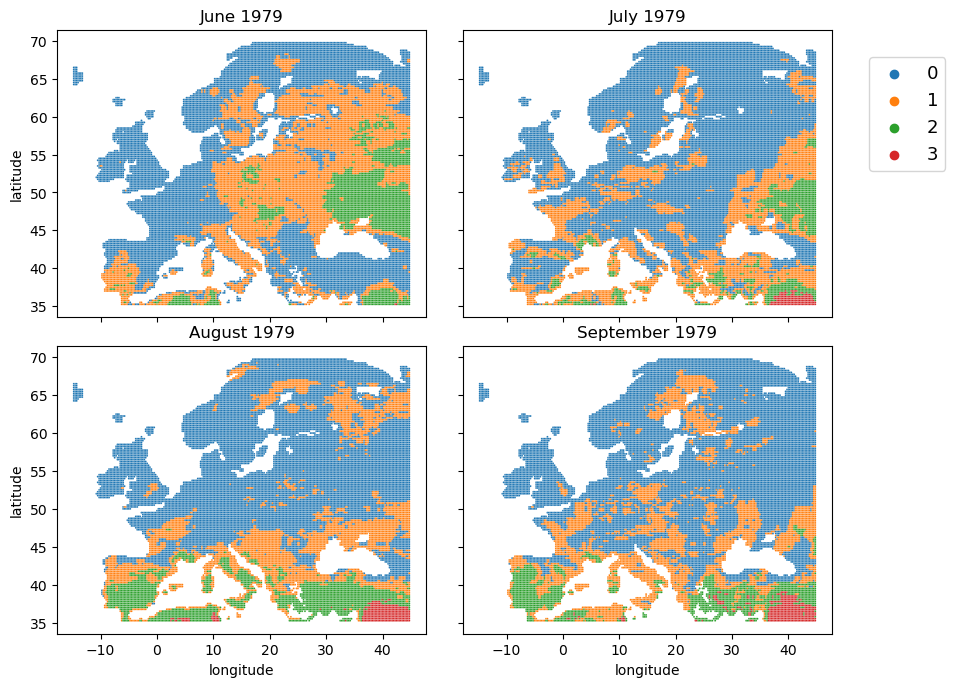

In [6]:
june_1979 = df_1979[df_1979['time'] == df_1979['time'].unique()[0]]
july_1979 = df_1979[df_1979['time'] == df_1979['time'].unique()[1]]
august_1979 = df_1979[df_1979['time'] == df_1979['time'].unique()[2]]
september_1979 = df_1979[df_1979['time'] == df_1979['time'].unique()[3]]


fig, ax = plt.subplots(2,2, figsize=(10,8), dpi=100, sharex=True, sharey=True)

sns.scatterplot(ax=ax[0,0], data=june_1979 ,x='longitude', 
                y='latitude', hue='label', palette='tab10', s=2)
sns.scatterplot(ax=ax[0,1], data=july_1979 ,x='longitude', 
                y='latitude', hue='label', palette='tab10', s=2, legend=False)
sns.scatterplot(ax=ax[1,0], data=august_1979 ,x='longitude', 
                y='latitude', hue='label', palette='tab10',  s=2, legend=False)
sns.scatterplot(ax=ax[1,1], data=september_1979 ,x='longitude', 
                y='latitude', hue='label', palette='tab10', s=2, legend=False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax[0,0].legend(loc=(2.2,0.51), prop={'size': 13})

ax[0,0].set_title('June 1979')
ax[0,1].set_title('July 1979')
ax[1,0].set_title('August 1979')
ax[1,1].set_title('September 1979')

plt.show();

## Random Forest Classifier

Now we have to train a Random Forest Classifier with the 1979 data. The excellent results on the test data suggest that the clusters are well defined, and the classifier is able to discriminate them easily.

In [7]:
X = df_1979.drop(['time','label'], axis=1)
y = df_1979['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=27)

scaler = RobustScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

random_forest = RandomForestClassifier(n_estimators=200, class_weight='balanced')
random_forest.fit(X_train,y_train)

label = random_forest.predict(X_test)

print(classification_report(y_test, label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17165
           1       0.98      0.98      0.98      8442
           2       0.98      0.97      0.98      2711
           3       1.00      0.98      0.99       369

    accuracy                           0.99     28687
   macro avg       0.99      0.98      0.98     28687
weighted avg       0.99      0.99      0.99     28687



<AxesSubplot:>

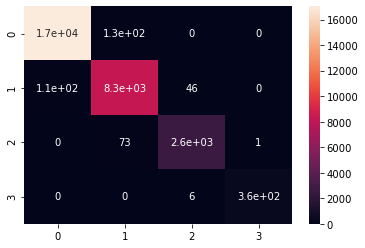

In [8]:
sns.heatmap(confusion_matrix(y_test, label), annot=True)

In order to complete our model we predict the rest of the data. Finally we have classified all the data, from 1979 to 2020 for every latitude and longitude.

In [9]:
df = df[len(df_1979):]
X = df.drop(['time'], axis=1)
results = random_forest.predict(X)

df['label'] = results
df = pd.concat([df,df_1979])

<ipython-input-9-6f8201f923cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = results


The correlation barplot shows that the danger risk has a great correlation with the label (almost 0.9). Furthermore, also the other features have strong correlation, suggesting that all the features are a good indicator to the wildfire susceptibility. 

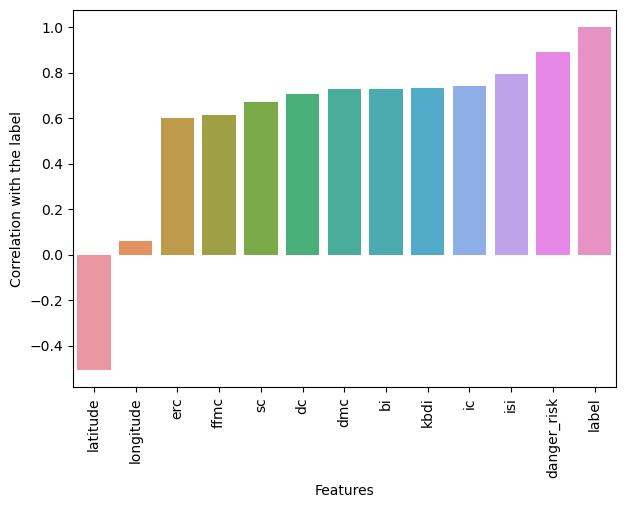

In [16]:
correlation_features = df.corr()['label'].sort_values()

plt.figure(figsize=(7,5), dpi=100)
sns.barplot(x=correlation_features.index, y=correlation_features.values)
plt.ylabel('Correlation with the label')
plt.xlabel('Features')
plt.xticks(rotation=90);

The figure below shows the time evolution of the number of danger zones. It is clear how the low risk zoned are decreasing every year. This suggests that the features index (that describe the climate and geological condition) are increasing their values. 

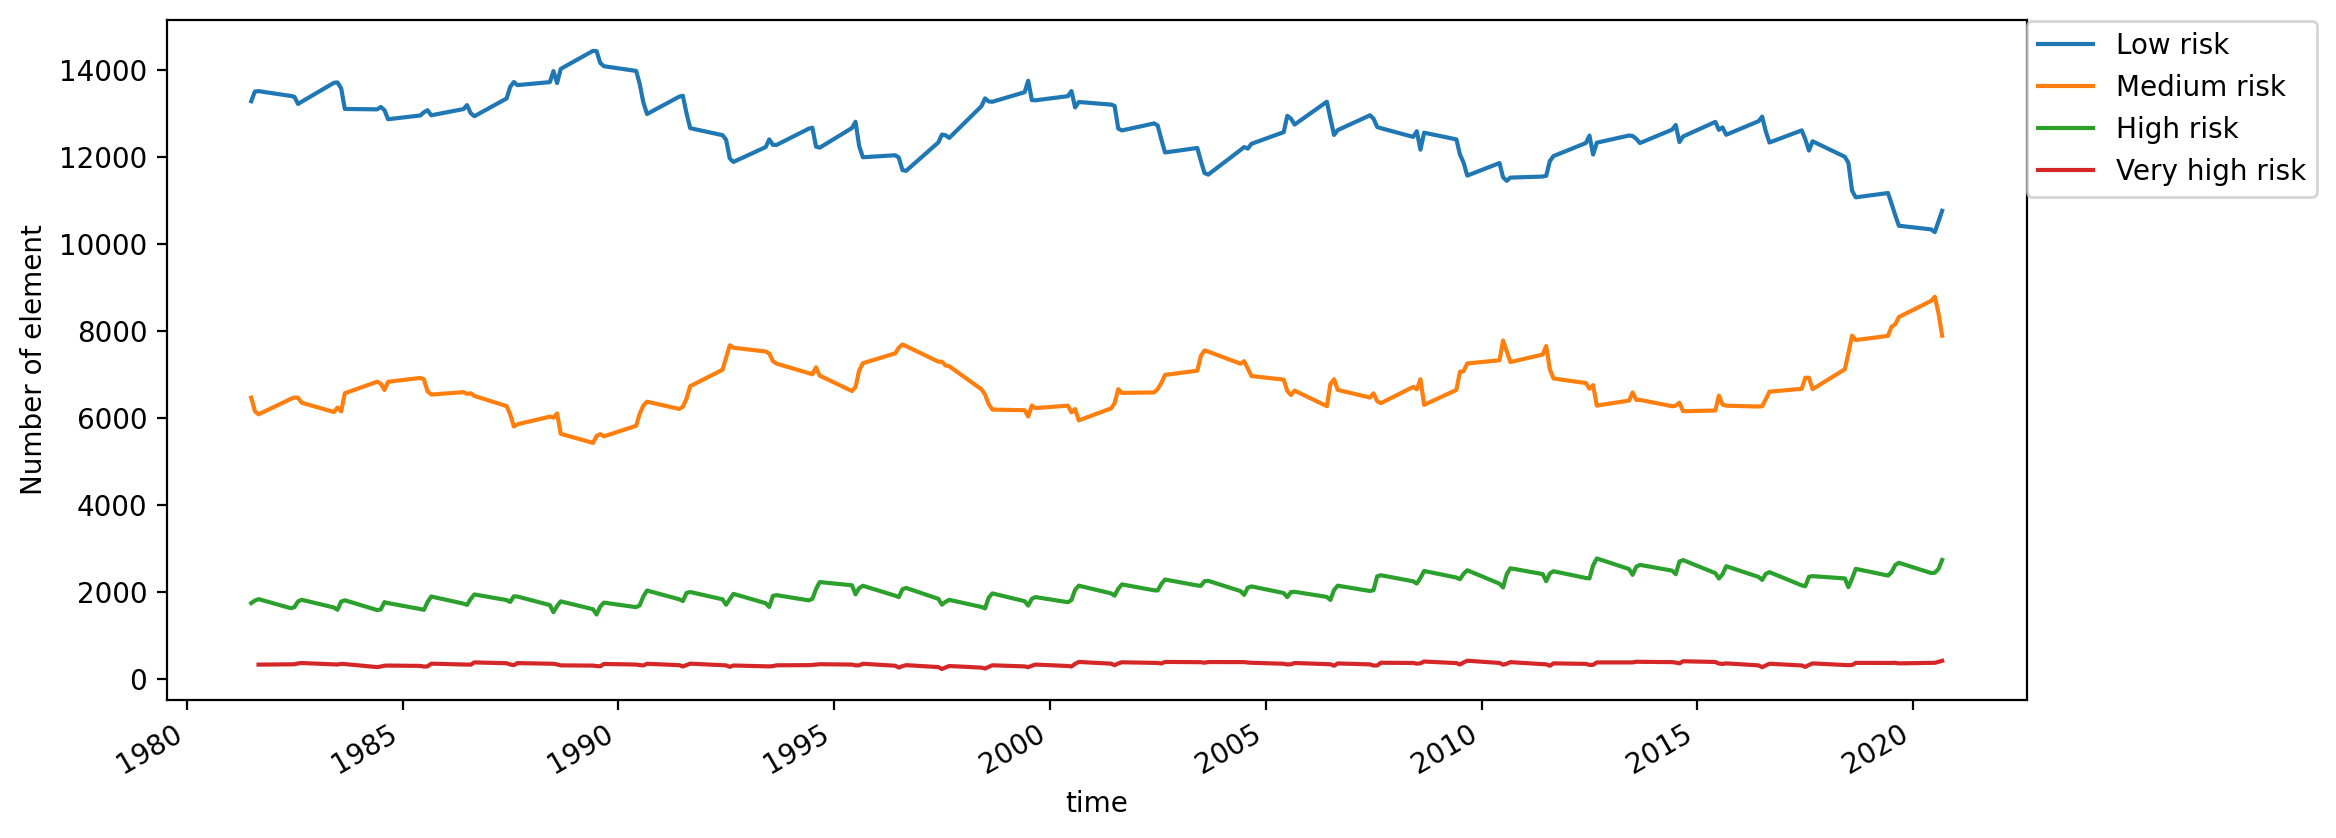

In [17]:
time_series = df.groupby(['label','time']).count()['bi']

plt.figure(figsize=(12,5), dpi=200)
for i in range(n_clusters):
    time_series.xs(i).rolling(window=10).mean().plot()
    plt.legend(['Low risk', 'Medium risk', 'High risk', 'Very high risk'], loc=(1,0.74))
    plt.ylabel('Number of element')

To study in detail the evolution of the different risk zones, we can observe their evolution separately; the medium, high and very high risk zones are growing over the year. The situation is alarming and we need fast intervention and a work on wildfires prevention to further avoid more serious consequences.

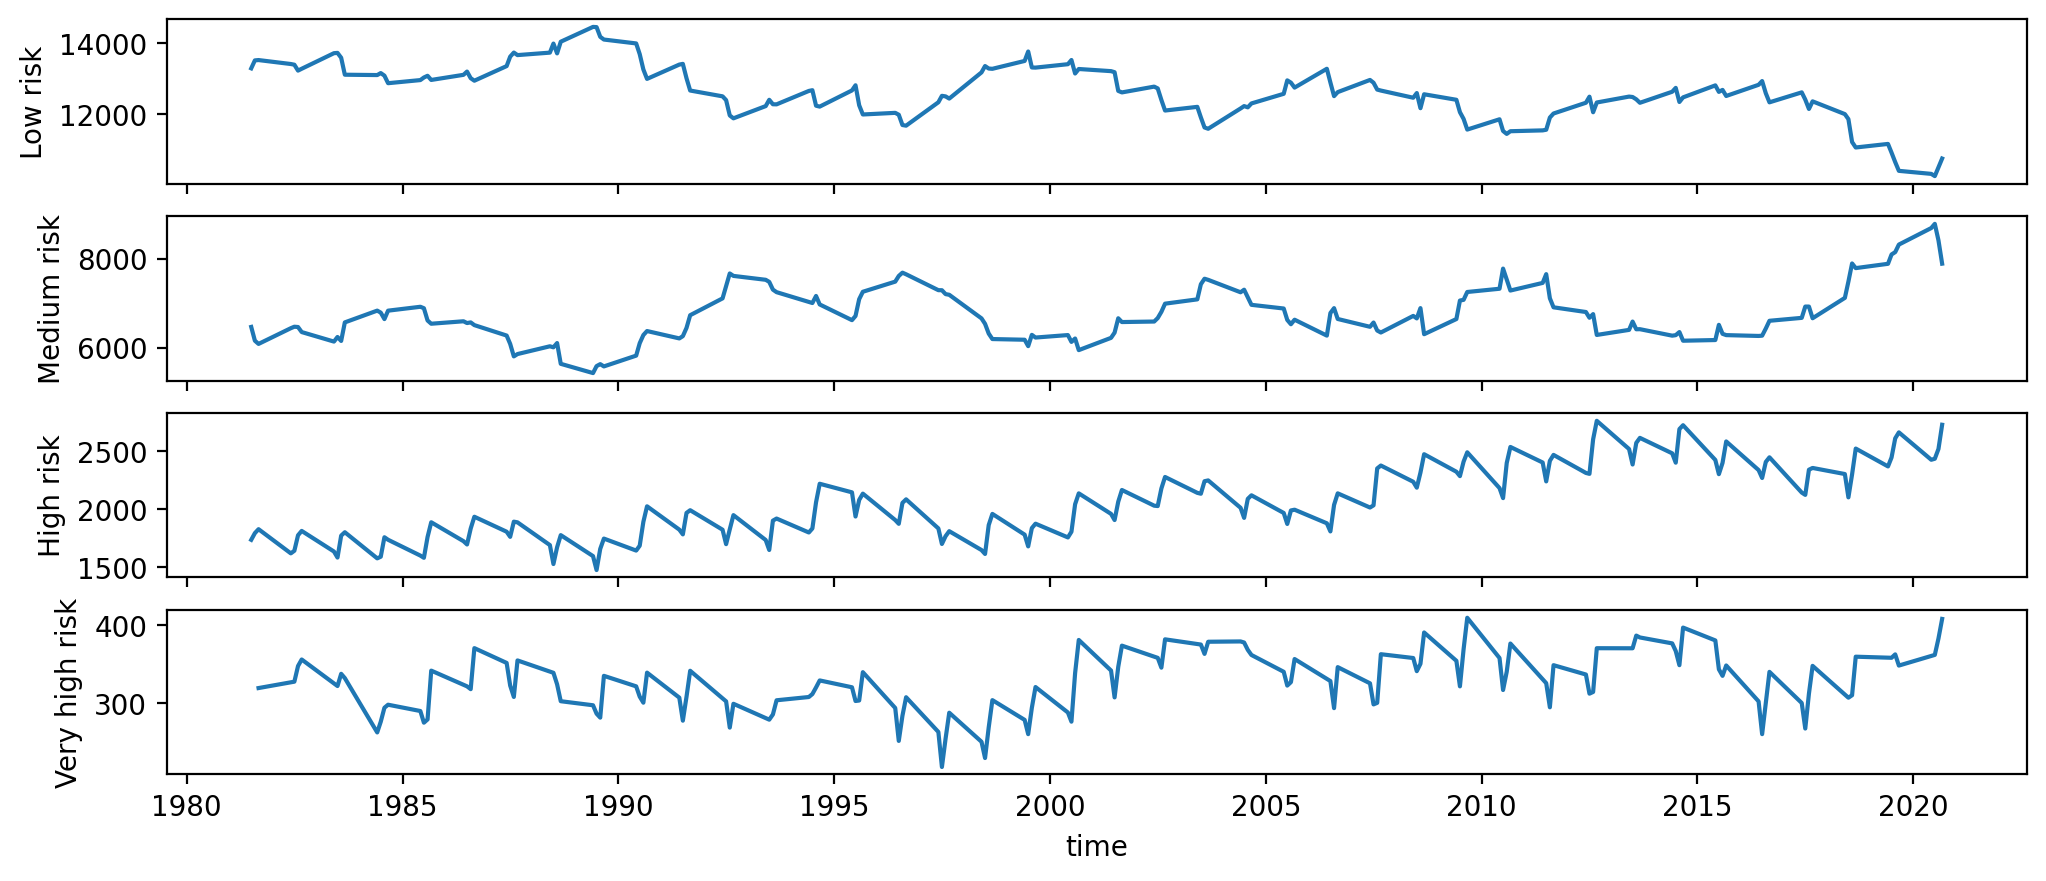

In [18]:
fig, ax = plt.subplots(n_clusters,1, figsize=(12,5), dpi=200, sharex=True)

for i in range(n_clusters):
    sns.lineplot(ax=ax[i], data=time_series.xs(i).rolling(window=10).mean())
    
ax[0].set_ylabel('Low risk')   
ax[1].set_ylabel('Medium risk')   
ax[2].set_ylabel('High risk')   
ax[3].set_ylabel('Very high risk')   
plt.show()

The last figure allows us to study the differences between two specific time intervals. We can observe the evolution of the danger zone with great precision over the entire european land. 

In [24]:
TIME_1 = '1979-08-01'
TIME_2 = '2020-08-01'

first_map = df[df['time'] == TIME_1]['label']
second_map = df[df['time'] == TIME_2]['label']

first_map = first_map.reset_index()['label']
second_map = second_map.reset_index()['label']

lotlan_map = df[df['time'] == TIME_1]
lotlan_map.reset_index(inplace=True)

scores = first_map - second_map
scores = pd.concat([lotlan_map[['longitude','latitude']], scores], axis=1)
scores.columns = ['longitude', 'latitude', 'Risk increase']

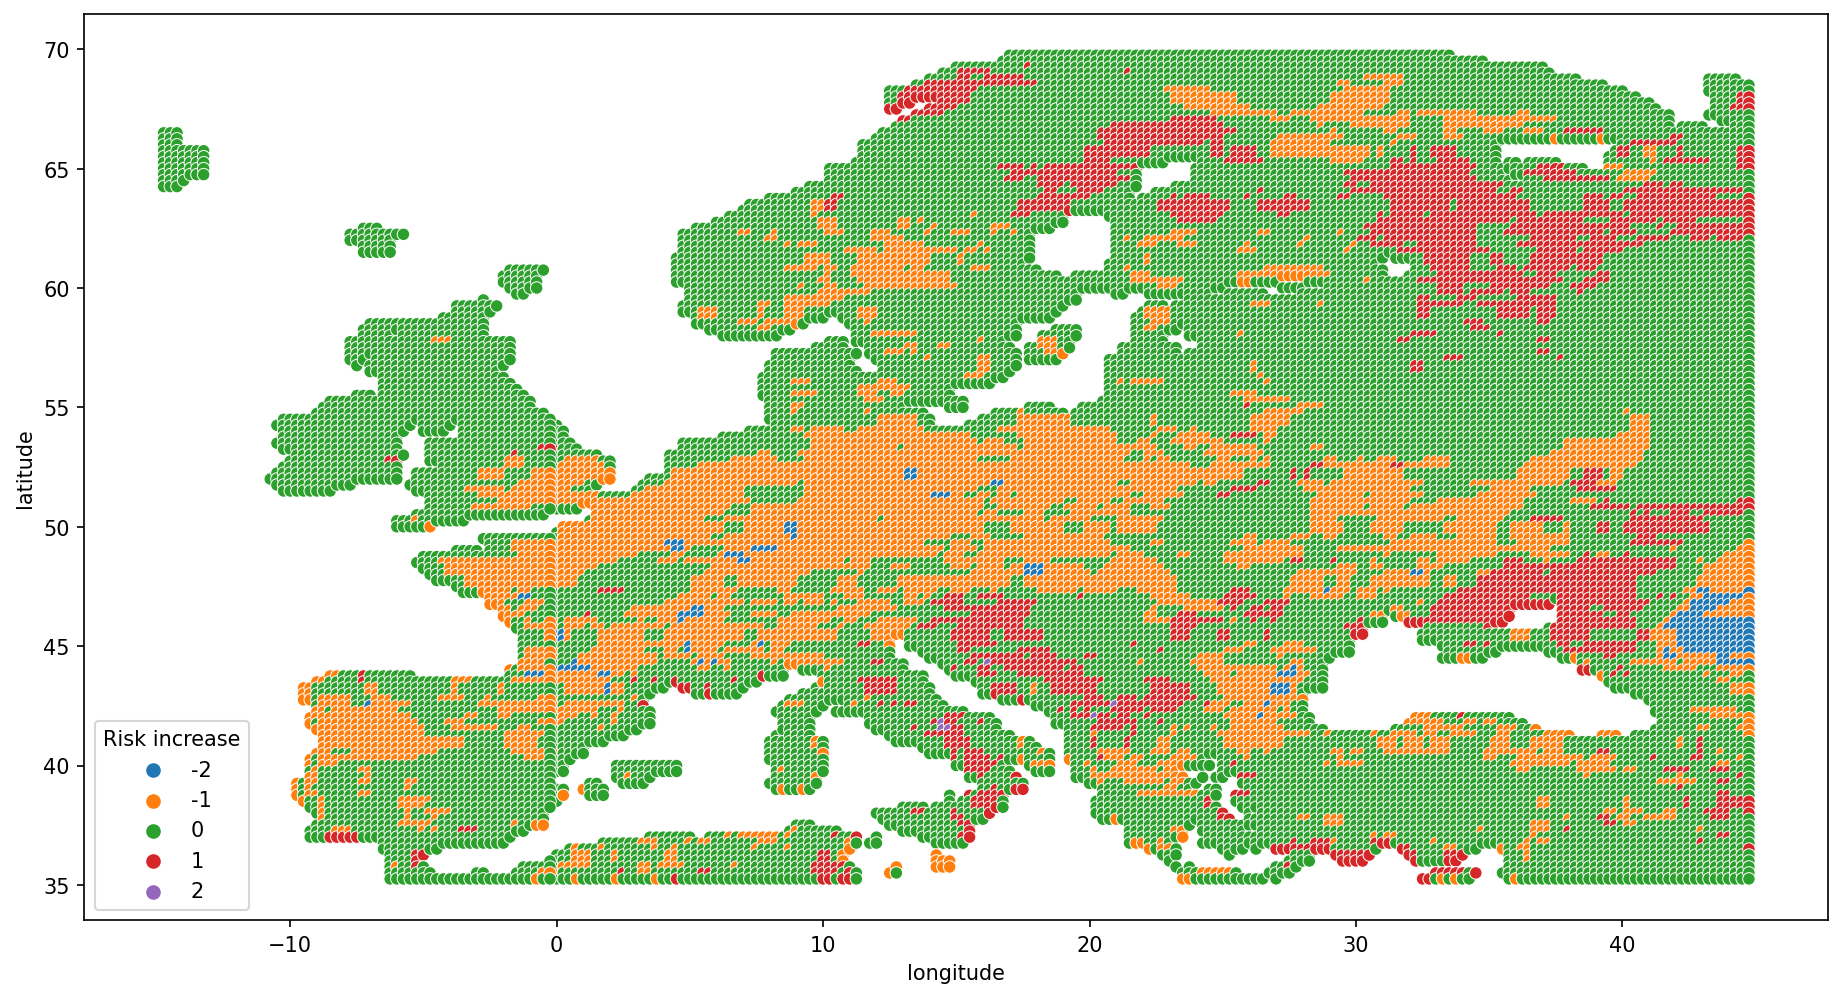

In [25]:
plt.figure(figsize=(15,8), dpi=150)
sns.scatterplot(data=scores, x='longitude', y='latitude', hue='Risk increase', palette='tab10');

In [15]:
df.to_pickle('Fire_danger_labeled.pkl')